## 使用信息熵寻找最优划分

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target

In [3]:
from sklearn.tree import DecisionTreeClassifier
# criterion="entropy"：划分标准：信息熵
dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [4]:
# 绘制不规则决策边界
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

D:\Anaconda\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


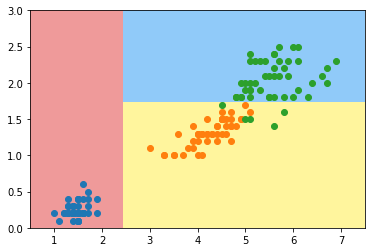

In [6]:
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])

## 模拟使用信息熵进行划分

In [7]:
# d：维度
# value：阈值
# 根据传入的维度和阈值进行划分
def split(X, y, d, value):
    index_a = (X[:, d] <= value)
    index_b = (X[:, d] > value)
    return X[index_a], X[index_b], y[index_a], y[index_b]

In [10]:
from collections import Counter
from math import log

# 计算信息熵
def entropy(y):
    counter = Counter(y) # 将y转换成一个字典，计算每一类有多少个样本：[1:5]    res = 0.0
    res = 0.0
    for num in counter.values():
        p = num / len(y) # 每一类相应的概率
        res += -p * log(p)
    return res
    
# 寻找维度和阈值
def try_split(X, y):
    best_entropy = float('inf')
    best_d, best_v = -1, -1
    for d in range(X.shape[1]):
        sorted_index = np.argsort(X[:, d])
        for i in range(1, len(X)):
            if X[sorted_index[i-1], d] != X[sorted_index[i], d]:
                v = (X[sorted_index[i-1], d] + X[sorted_index[i], d]) / 2
                X_l, X_r, y_l, y_r = split(X, y, d, v)
                e = entropy(y_l) + entropy(y_r)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v
    return best_entropy, best_d, best_v                

In [11]:
try_split(X, y)

(0.6931471805599453, 0, 2.45)

In [12]:
best_entropy, best_d, best_v = try_split(X, y)
print("best_entropy = ", best_entropy)
print("best_d = ", best_d)
print("best_v = ", best_v)

best_entropy =  0.6931471805599453
best_d =  0
best_v =  2.45


通过上面的图示，我们发现第一次划分是在 x 轴上进行划分的，所以 best_d = 0.

In [13]:
# 划分后的数据
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

In [14]:
entropy(y1_l)

0.0

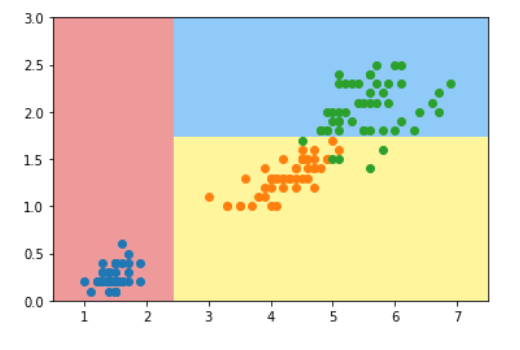
根据上图，第一划分，所有的数据都划分到了左边，此时没有任何不确定性，信息熵为0。

In [15]:
entropy(y1_r)

0.6931471805599453

In [16]:
best_entropy2, best_d2, best_v2 = try_split(X1_r, y1_r) # 继续划分
print("best_entropy = ", best_entropy2)
print("best_d = ", best_d2)
print("best_v = ", best_v2)

best_entropy =  0.4132278899361904
best_d =  1
best_v =  1.75


In [18]:
# 划分后的数据
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

In [19]:
entropy(y2_l)

0.30849545083110386

In [20]:
entropy(y2_r)

0.10473243910508653

我们发现它们的信息熵都没有降为0，所以还可以继续划分。但是之前创建对象时设置了`max_depth=2`，所以划分到此为止了。

dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")

但是我们这里只是进行了划分，但是还没有真正将决策树构建起来。